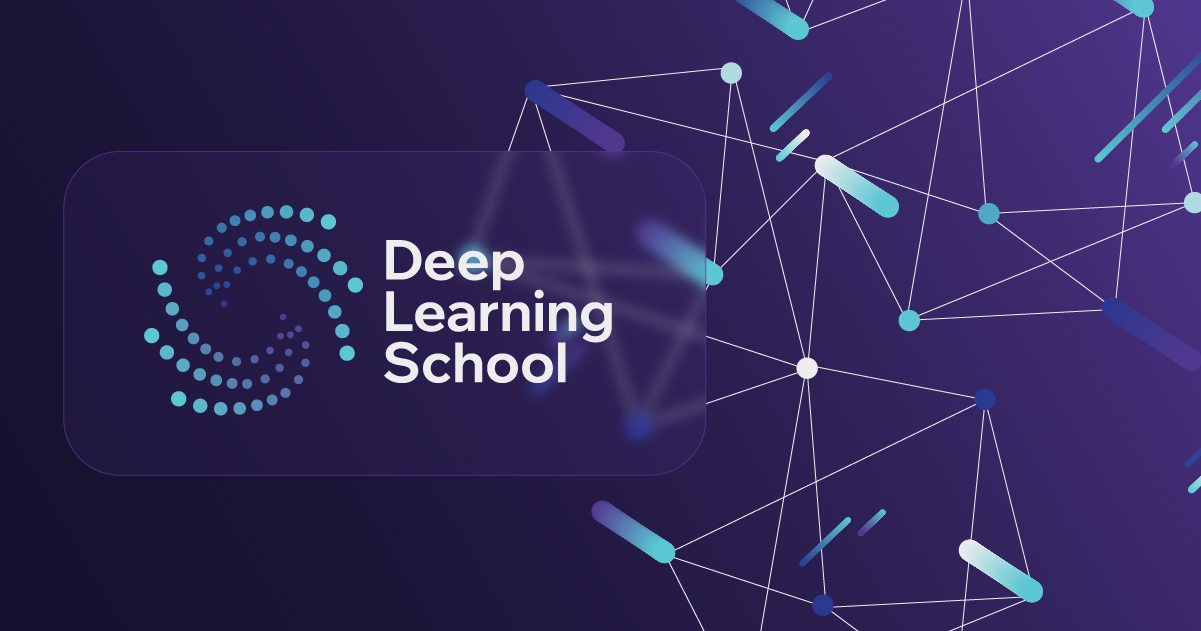


На семинаре было показано, как можно обучить классический GAN. Такая версия модели имеет множество недостатков, поэтому в этом домашнем задании вы модифицируете код с семинара, обучив более сложную модель **WGAN-GP** генерировать аниме-лица, а также посмотрите на то, как можно оценивать качество генерации.

За эту работу можно получить до 10 баллов. В заданиях есть ячейки, в которых вы должны будете написать ответ словами. Не пропускайте их, они тоже оцениваются.

## Часть 1. Подготовка данных

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

### Загрузка датасета Anime Face Dataset

Датасет [Anime Face Dataset](https://www.kaggle.com/datasets/splcher/animefacedataset) представляет собой набор из 63,632 "high-quality" изображений аниме лиц размером 63х63.



Давайте загрузим наши картинки.

In [2]:
# Установка kagglehub, если вы работаете не в Google Colab
# !pip install kagglehub

In [3]:
import kagglehub
import os
import shutil

# Укажите путь к папке, куда хотите скачать датасет
target_folder = 'datasets/anime_faces'
os.makedirs(target_folder, exist_ok=True)

# Загрузка последней версии датасета
path = kagglehub.dataset_download("splcher/animefacedataset")

# Перемещение загруженных файлов в целевую папку
for file in os.listdir(path):
    shutil.move(os.path.join(path, file), os.path.join(target_folder, file))

print("Датасет успешно загружен в папку:", target_folder)

Датасет успешно загружен в папку: datasets/anime_faces


Если у вас возникли трудности со скачиванием датасета при помощи kagglehub, то можете скачать его  [напрямую с Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset).


Подготовим dataloader для обучения нашего будущего WGAN-GP

In [4]:
# Загрузка Anime Faces Dataset
def prepare_dataset(data_path, img_size, batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)
    return dataloader

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
img_size = 64

In [6]:
dataloader = prepare_dataset(target_folder, img_size, batch_size)

Посмотрим, как выглядят наши изображения

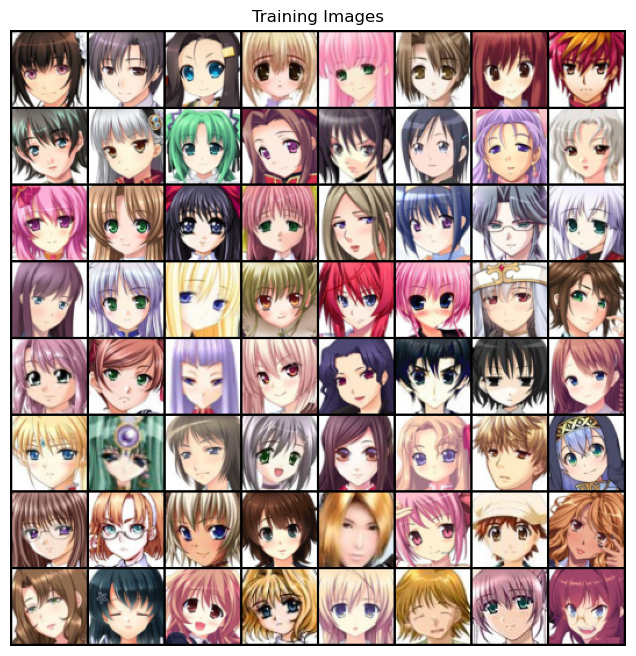

In [7]:
import torchvision.utils as vutils

# Отрисовка изображений из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show();

##Часть 2. Wasserstein GAN with Gradient Penalty: WGAN-GP (8 баллов)

### Проблемы классических GAN (теория)

Перед тем, как говорить про WGAN-GP, вспомним, какие были проблемы у классических GAN.



1.   **Vanishing gradients** — одна из главных проблем классических GAN, которая возникает в ситуации, когда дискриминатор становится слишком "сильным" и легко различает реальные и сгенерированные данные. В этом случае, градиенты генератора становятся слишком маленькими, что приводит к плохому обучению модели.

2.   **Mode collapse** — это проблема, при которой генератор начинает производить множество однотипных сэмплов, не используя всё разнообразие тренировочных данных, например, как показано на картинке ниже. Кстати, она сгенерирована той же архитетурой GAN, которая была показана на семинаре.

3. **Интерпретация лосса при обучении** - бинарная кросс-энтропия напрямую не измеряет расстояние между реальным и генерируемым распределениями, она лишь отражает способность дискриминатора различать реальные и фейковые данные. Если генератор производит плохие сэмплы, loss дискриминатора всё равно может уменьшаться, что создает ложное представление о прогрессе обучения.

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1ShXxZqVD9cXZIuHzeW_tbO-StV-uxCy5" width=787 height=148/></p>



### Что такое WGAN-GP и как он решает проблемы классического GAN? (теория)

На самом деле, правильнее будет сказать, что WGAN-GP - это модификация WGAN, нежели классического GAN. То есть, мы пропустили один важный промежуточный этап. Однако с точки зрения реализации WGAN-GP не на много сложнее, чем WGAN. При этом результаты получаются лучше. Но начнем мы именно с этого промежуточного этапа - WGAN. Что же это такое и в чем отличие по сравнению с классическим GAN?

Первое, о чем стоит поговорить - это функция потерь. Дискриминатор классического GAN работает как бинарный классификатор, выдавая **вероятности** для реальных и фейковых данных на выходе. Поэтому в качестве функции потерь используется бинарная кросс-энтропия:

$L_{\text{discriminator}} = -\mathbb{E}_{x \sim p_{\text{data}}} [\log D(x)] - \mathbb{E}_{z \sim p_z} [\log(1 - D(G(z)))]$

$L_{\text{generator}} = -\mathbb{E}_{z \sim p_z} [\log D(G(z))]$


Именно здесь и кроятся основные проблемы GAN'ов, про которые мы говорили выше. Когда дискриминатор достигает идеальной точности ($D(x)\approx 1$ для реальных данных и $D(G(z))\approx 0$ для фейковых), производная лосса генератора $\mathbb{E}_{z \sim p_z} [\log D(G(z))]$ может стремиться к нулю (это не совсем тривиальное утверждение, но доказательство мы здесь опустим). Это приводит к тому, что генератор перестаёт получать полезные сигналы для обучения (vanishing gradients). Также, такой лосс не учитывает разнообразие тренировочных данных, и генератор может находить локальный оптимум, где он производит один или несколько типов данных, которые легко обманывают дискриминатор (mode-collapse).




Идея модификации заключается в отказе от бинарной кросс-энтропии. Вместо этого в модели WGAN используется Wasserstein-расстояние.

$W(p_{\text{data}}, p_{\text{gen}}) = \inf_{\gamma \in \Pi(p_{\text{data}}, p_{\text{gen}})} \mathbb{E}_{(x, y) \sim \gamma} [\|x - y\|]$

Да уж... формула выглядит страшновато, но, как очень часто бывает, на практике она нам не понадобится из-за сложности для прямого вычисления. При обучении WGAN используются следующие формулы:

$W(p_{\text{data}}, p_{\text{gen}}) = -L_{\text{critic}} = \sup_{\|C\|_L \leq 1} \left( \mathbb{E}_{x \sim p_{\text{data}}} [C(x)] - \mathbb{E}_{z \sim p_z} [C(G(z))] \right)$

$L_{\text{generator}} = -\mathbb{E}_{z \sim p_z} [C(G(z))]$

Скорее всего, вы заметили новое обозначение $C(x)$. В теории WGAN'ов таким образом обозначается то, что раньше мы называли дискриминатором $D(x)$. Теперь модель, которую пытается обмануть генератор, называется **"Критик" ("Critic")**. Главное отличие критика от дискриминатора заключается в том, что критик - не бинарный классификатор. **На выходе у критика не вероятности, а некоторая численная оценка**, для которой при обучении подсчитывается Wasserstein-расстояние. Также, в процессе обучения происходит клиппирование весов критика $\|C\|_L \leq 1$, чтобы сохранить его липшевость (подробнее об этом чуть позже). **Во всем остальном критик и дискриминатор идентичны**.

Такой подход позволяет успешно бороться с проблемами классических GAN:

1.   **Mode-collapse**: Wasserstein-дистанция учитывает всю структуру распределений, что побуждает генератор создавать разнообразные образцы.
2.   **Vanishing gradients**:
Генератор всегда получает полезные сигналы для обучения, даже если он находится далеко от целевого распределения.
3. **Интерпретация лосса при обучении**: Wasserstein-дистанция является более естественной метрикой для сравнения распределений, чем бинарная кросс-энтропия. Она напрямую показывает, насколько одно распределение отличается от другого, поэтому в процессе обучения лосс должен монотонно уменьшаться.






Подведем итоги

|               | **Классический GAN**                          | **WGAN**                                    |
|--------------------------|-----------------------------------------------|------------------------------------------------|
| **Функция потерь**       | Бинарная кросс-энтропия                       | Wasserstein-дистанция      |
| **Выход модели**         | Вероятность \($ D(x) \in [0, 1] $ \)          | Скалярное значение \($ C(x) \in \mathbb{R} $\) |                           |
| **Стабильность обучения**| Нестабильное обучение                         | Гораздо более стабильное обучение               |
| **Mode collapse**         | Часто встречается                             | Реже встречается                               |
| **Поведение градиентов**     | Исчезающие градиенты (vanishing gradients)     | Постоянные и значимые градиенты                 |
| **Интерпретируемость**      | Loss сложно интерпретировать                   | Loss монотонно уменьшается                     |

Более подробно и математически строго про WGAN можно почитать в [оригинальной статье](https://arxiv.org/pdf/1701.07875).

### Построение модели (2 балла)

Сконструируйте модели генератора и критика. В этом задании подразумевается, что за основу вы возьмете код с семинара, однако при желании вы можете экспериментировать. Главное - помните, что критик на выходе выдает не вероятности, а просто некоторые **скалярные значения**, во всем остальном модели могут быть идентичными.

In [8]:
latent_size = 128

In [9]:
# Генератор (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
        # in: latent_size x 1 x 1
    
        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # out: 512 x 4 x 4
    
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # out: 256 x 8 x 8
    
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 16 x 16
    
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # out: 64 x 32 x 32
    
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
        # out: 3 x 64 x 64
    )

    def forward(self, z):
        x = self.model(z)
        return x

In [10]:
# Критик (Critic)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        # архитектура та же, что на семинаре,
        # но на выходе вектор из скаляров, а не вектор вероятностей
        self.model = nn.Sequential(
        # in: 3 x 64 x 64
    
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 64 x 32 x 32
    
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 128 x 16 x 16
    
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 8 x 8
    
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 512 x 4 x 4
    
        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1
    
        nn.Flatten()
        )

    def forward(self, img):
        return self.model(img)

### Градиентный штраф (Gradient Penalty) и WGAN-GP (теория)

В WGAN критик $C(x)$ должен быть липшицевой функцией , то есть его производная должна быть ограничена:

$\|\nabla_{\hat{x}} C(\hat{x})\|_2 \leq 1$

Это требование необходимо для корректного вычисления Wasserstein-дистанции.

В оригинальном WGAN для обеспечения Липшицевости применяется клиппирование весов:

$w \in \[-c, c]\$,

где $w$ - параметры критика, а $c$ - некоторое маленькое число.

Однако такой подход слишком жестко ограничивает диапозон значений весов, что часто приводит к нестабильности обучения и плохой сходимости.

Альтернативой клиппирования является **градиентный штраф (Gradient Penalty)**, который представляет собой метод регуляризации весов, и добавляется в функцию потерь критика с некоторым коэффициентом $\lambda$:

$L_{\text{critic}} = -\mathbb{E}_{x \sim p_{\text{data}}} [C(x)] + \mathbb{E}_{z \sim p_z} [C(G(z))] + \lambda L_{\text{GP}}$

$L_{\text{GP}} = \mathbb{E}_{\hat{x} \sim P_{\hat{x}}} \left[ (\|\nabla_{\hat{x}} C(\hat{x})\|_2 - 1)^2 \right]$





**Как это работает?**


1) Создается интерполяция между реальными ($x_{real}$) и фейковыми ($x_{fake}$) данными

$\hat{x} = \alpha x_{\text{real}} + (1 - \alpha) x_{\text{fake}}$,

где $\alpha$ сэмплируется из равномерного распределения $\alpha \sim U(0, 1).$

2) Вычисляется норма градиента критика по интерполированным данным:

$\|\nabla_{\hat{x}} C(\hat{x})\|_2$

3) Добавляется штраф за отклонение нормы градиента от 1 и усредняется по всем интерполированным точкам

$L_{\text{GP}} = \mathbb{E}_{\hat{x} \sim P_{\hat{x}}} \left[ (\|\nabla_{\hat{x}} C(\hat{x})\|_2 - 1)^2 \right]$

Более подробно о градиентном штрафе можно почитать в [оригинальной статье](https://arxiv.org/pdf/1704.00028).

### Напишите функцию для вычисления градиентного штрафа $L_{\text{GP}}$ (2 балла)

In [11]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """
    Вычисляет градиентный штраф для WGAN-GP.

    :param critic: Модель критика.
    :param real_images: Тензор с реальными изображениями.
    :param fake_images: Тензор с фейковыми изображениями.
    :param device: Устройство для вычислений CPU/GPU.
    :return: Градиентный штраф
    """

    # Создание интерполированных данных, используйте torch.rand для сэмплирования alpha
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    x_hat = alpha * real_samples + (1 - alpha) * fake_samples
    x_hat = x_hat.requires_grad_(True)

    # Вычисление выхода критика для интерполированных данных
    critic_interpolates = critic(x_hat)

    # Подготовка градиентов
    grad_outputs = torch.ones_like(critic_interpolates, device=device)

    # Вычисление градиента по интерполированным данным
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=x_hat,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Вычисление нормы градиента
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)

    # Вычисление градиентного штрафа (мат ожидание = усреднение)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()

    return gradient_penalty

In [12]:
from tqdm import tqdm

def show_generated_images(generator, latent_size, device, num_images=5):
    """Выводит сгенерированные изображения."""
    generator.eval()
    with torch.no_grad():
        # обратите внимание на размерность сгенированных векторов
        z = torch.randn(num_images, latent_size, 1, 1, device=device)
        generated_images = generator(z).cpu()  # Генерируем изображения

    # Нормализация значений пикселей для отображения
    generated_images = (generated_images + 1) / 2.0  # Из диапазона [-1, 1] в [0, 1]

    # Визуализация
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(np.transpose(
        vutils.make_grid(
            generated_images,
            padding=2,
            normalize=True
            ).cpu(),
         (1, 2, 0)))
    plt.show();

    generator.train()

### Напишите функцию для обучения WGAN-GP (2 балла)

Ваша задача - реализовать процесс обучения WGAN-GP. По своей структуре он не сильно отличается от того, что было показано на семинаре для классических GAN. В первую очередь, вам нужно правильно прописать все лоссы:

$L_{\text{critic}} = -\mathbb{E}_{x \sim p_{\text{data}}} [C(x)] + \mathbb{E}_{z \sim p_z} [C(G(z))] + \lambda L_{\text{GP}}$

$L_{\text{GP}} = \mathbb{E}_{\hat{x} \sim P_{\hat{x}}} \left[ (\|\nabla_{\hat{x}} C(\hat{x})\|_2 - 1)^2 \right]$

$L_{\text{generator}} = -\mathbb{E}_{z \sim p_z} [C(G(z))]$



Помимо этого, вам нужно будет реализовать еще одну хитрость, которую советуют авторы статей. Веса генератора должны обновляться реже, чем веса критика. За это отвечает параметр $n_{critic}$. **Через критика градиенты должны протекать на каждом батче, а через генератор только на каждом кратном $n_{critic}$ батче**. Это позволяется добиться лучшего баланса между критиком и генератором.

Итоговый алгоритм обучения выглядит следующим образом:



![image.png](attachment:image.png)

За подробностями предлагается обратиться к статьям: [WGAN](https://arxiv.org/pdf/1701.07875), [WGAN-GP](https://arxiv.org/pdf/1704.00028).


In [13]:
def train(dataloader, generator, critic, optimizer_C, optimizer_G, epochs, lambda_gp, n_critic, device, num_images):
    """
    :param dataloader: Подготовленный даталоадер
    :param generator:  Модель генератора.
    :param critic:     Модель критика.
    :param optimizer_C: Оптимизатор для критика.
    :param optimizer_G: Оптимизатор для генератора.
    :param epochs:    Количество эпох для обучения модели.
    :param lambda_gp:  Коэффициент для градиентного штрафа.
    :param n_critic:   Количество шагов обучения критика перед каждым шагом генератора.
    :param device:     Устройство для вычислений.
    :param num_images:  Количество изображений для вывода в процессе обучения (например, 25 для сетки 5x5).
    :return: списки лоссов генератора и критика в процессе обучения
    """

    g_losses, c_losses = [], []

    for epoch in tqdm(range(epochs)):
        for i, (real_imgs, _) in enumerate(tqdm(dataloader)):
            real_imgs = real_imgs.to(device)

            # ---------------------
            # Train Critic
            # ---------------------
            optimizer_C.zero_grad()

            # Генерация фейковых изображений
            z = torch.randn(real_imgs.size(0), latent_size, 1, 1, device=device)
            fake_imgs = generator(z).detach()

            # Вычисление loss для реальных и фейковых изображений
            real_loss = -critic(real_imgs).mean()
            fake_loss = critic(fake_imgs).mean()
            gradient_penalty = compute_gradient_penalty(
                critic,
                real_imgs,
                fake_imgs,
                device
            )
            c_loss = real_loss + fake_loss + lambda_gp * gradient_penalty

            c_loss.backward()
            optimizer_C.step()

            # -----------------
            # Train Generator
            # -----------------
            if i % n_critic == 0:
                optimizer_G.zero_grad()

                # Генерация новых фейковых изображений
                z = torch.randn(real_imgs.size(0), latent_size, 1, 1, device=device)
                gen_imgs = generator(z)


                g_loss = -critic(gen_imgs).mean()

                g_loss.backward()
                optimizer_G.step()

            # Сохранение лоссов
            c_losses.append(c_loss.item())
            g_losses.append(g_loss.item())

        # Вывод прогресса обучения
        print(f"[Epoch {epoch + 1}/{epochs}] [Loss C: {c_losses[-1]}] [Loss G: {g_losses[-1]}]")
        # Вывод сгенерированных изображений каждые 5 эпох
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Generated images at epoch {epoch + 1}:")
            show_generated_images(generator, latent_size, device, num_images=num_images)
    return g_losses, c_losses

### Обучение WGAN-GP (2 балла)

С параметрами обучения можете поэкспериментировать или взять стандартные из статьи.



In [14]:
# Инициализация моделей
generator = Generator().to(device)
critic = Critic().to(device)

lr = 1e-4 
n_critic = 5
lambda_gp = 10
epochs = 50
num_images = 8

# Оптимизаторы
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(0.0, 0.9)
)
optimizer_C = torch.optim.Adam(
    critic.parameters(),
    lr=lr,
    betas=(0.0, 0.9)
)

### Графики лоссов

Отрисуйте лоссы. Что вы можете сказать про полученные графики? Согласуются ли они с теорией?

100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [03:18<00:00,  5.00it/s]

[Epoch 1/50] [Loss C: -22.877017974853516] [Loss G: 14.92008113861084]
Generated images at epoch 1:


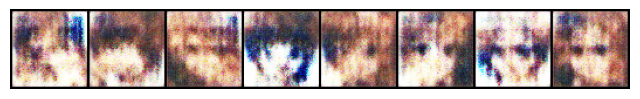

  4%|███▏                                                                             | 2/50 [03:42<1:16:37, 95.78s/it]

[Epoch 2/50] [Loss C: -16.471168518066406] [Loss G: 5.395782947540283]



  6%|████▉                                                                              | 3/50 [04:06<49:18, 62.95s/it]

[Epoch 3/50] [Loss C: -10.047348022460938] [Loss G: 5.935789108276367]



  8%|██████▋                                                                            | 4/50 [04:30<36:32, 47.67s/it]

[Epoch 4/50] [Loss C: -10.393860816955566] [Loss G: -1.0531741380691528]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:24<00:00, 41.15it/s]

[Epoch 5/50] [Loss C: -8.817745208740234] [Loss G: 3.1367712020874023]
Generated images at epoch 5:


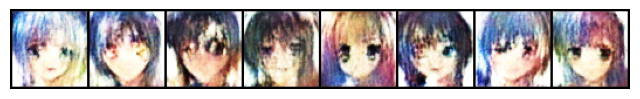

 12%|█████████▉                                                                         | 6/50 [05:18<24:52, 33.93s/it]

[Epoch 6/50] [Loss C: -7.570207118988037] [Loss G: 1.2339445352554321]



 14%|███████████▌                                                                       | 7/50 [05:42<21:56, 30.62s/it]

[Epoch 7/50] [Loss C: -9.270699501037598] [Loss G: 2.958223342895508]



 16%|█████████████▎                                                                     | 8/50 [06:06<19:58, 28.53s/it]

[Epoch 8/50] [Loss C: -8.634268760681152] [Loss G: 0.09134948253631592]



 18%|██████████████▉                                                                    | 9/50 [06:30<18:37, 27.26s/it]

[Epoch 9/50] [Loss C: -8.211225509643555] [Loss G: 3.704838991165161]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:25<00:00, 39.27it/s]

[Epoch 10/50] [Loss C: -8.287772178649902] [Loss G: -1.332431674003601]
Generated images at epoch 10:


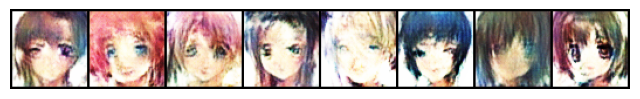

 22%|██████████████████                                                                | 11/50 [07:20<16:50, 25.91s/it]

[Epoch 11/50] [Loss C: -7.3504228591918945] [Loss G: 4.998394966125488]



 24%|███████████████████▋                                                              | 12/50 [07:44<16:03, 25.36s/it]

[Epoch 12/50] [Loss C: -6.343719482421875] [Loss G: 2.6024484634399414]



 26%|█████████████████████▎                                                            | 13/50 [08:08<15:22, 24.93s/it]

[Epoch 13/50] [Loss C: -6.945189952850342] [Loss G: 1.2019307613372803]



 28%|██████████████████████▉                                                           | 14/50 [08:32<14:46, 24.62s/it]

[Epoch 14/50] [Loss C: -6.637065410614014] [Loss G: 3.0706405639648438]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:23<00:00, 41.66it/s]

[Epoch 15/50] [Loss C: -7.152854919433594] [Loss G: 4.389273643493652]
Generated images at epoch 15:


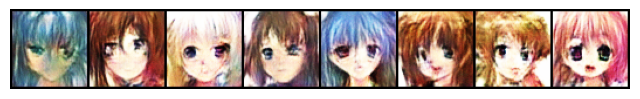

 32%|██████████████████████████▏                                                       | 16/50 [09:19<13:42, 24.18s/it]

[Epoch 16/50] [Loss C: -7.228359222412109] [Loss G: 1.1289466619491577]



 34%|███████████████████████████▉                                                      | 17/50 [09:43<13:15, 24.10s/it]

[Epoch 17/50] [Loss C: -6.439991474151611] [Loss G: 4.219334602355957]



 36%|█████████████████████████████▌                                                    | 18/50 [10:07<12:48, 24.02s/it]

[Epoch 18/50] [Loss C: -6.701697826385498] [Loss G: 1.8358665704727173]



 38%|███████████████████████████████▏                                                  | 19/50 [10:31<12:25, 24.03s/it]

[Epoch 19/50] [Loss C: -5.651543617248535] [Loss G: 0.7051993608474731]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:24<00:00, 40.38it/s]

[Epoch 20/50] [Loss C: -5.991034507751465] [Loss G: -3.068052291870117]
Generated images at epoch 20:


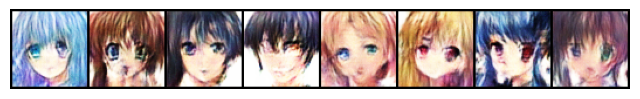

 42%|██████████████████████████████████▍                                               | 21/50 [11:22<11:57, 24.73s/it]

[Epoch 21/50] [Loss C: -6.342959880828857] [Loss G: 1.0332766771316528]



 44%|████████████████████████████████████                                              | 22/50 [11:46<11:31, 24.70s/it]

[Epoch 22/50] [Loss C: -5.178994178771973] [Loss G: 1.0885627269744873]



 46%|█████████████████████████████████████▋                                            | 23/50 [12:11<11:05, 24.64s/it]

[Epoch 23/50] [Loss C: -5.737374305725098] [Loss G: 5.386434555053711]



 48%|███████████████████████████████████████▎                                          | 24/50 [12:35<10:33, 24.37s/it]

[Epoch 24/50] [Loss C: -4.641897678375244] [Loss G: 4.520018577575684]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:23<00:00, 41.88it/s]

[Epoch 25/50] [Loss C: -6.630816459655762] [Loss G: 1.292356014251709]
Generated images at epoch 25:


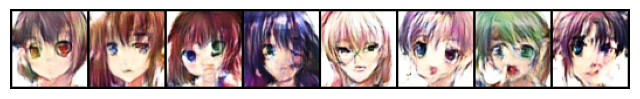

 52%|██████████████████████████████████████████▋                                       | 26/50 [13:22<09:38, 24.11s/it]

[Epoch 26/50] [Loss C: -6.6092376708984375] [Loss G: -1.385477900505066]



 54%|████████████████████████████████████████████▎                                     | 27/50 [13:46<09:13, 24.07s/it]

[Epoch 27/50] [Loss C: -5.7994537353515625] [Loss G: 0.4572221338748932]



 56%|█████████████████████████████████████████████▉                                    | 28/50 [14:10<08:49, 24.05s/it]

[Epoch 28/50] [Loss C: -6.214168548583984] [Loss G: -4.264519691467285]



 58%|███████████████████████████████████████████████▌                                  | 29/50 [14:34<08:23, 23.97s/it]

[Epoch 29/50] [Loss C: -5.208762168884277] [Loss G: 0.12156634032726288]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:24<00:00, 41.31it/s]

[Epoch 30/50] [Loss C: -5.154665470123291] [Loss G: 2.90697979927063]
Generated images at epoch 30:


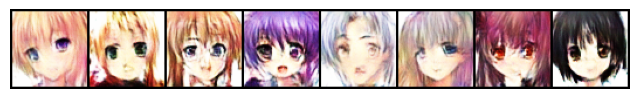

 62%|██████████████████████████████████████████████████▊                               | 31/50 [15:23<07:40, 24.24s/it]

[Epoch 31/50] [Loss C: -5.017475128173828] [Loss G: 2.9105563163757324]



 64%|████████████████████████████████████████████████████▍                             | 32/50 [15:47<07:17, 24.30s/it]

[Epoch 32/50] [Loss C: -4.632360458374023] [Loss G: -0.5788118243217468]



 66%|██████████████████████████████████████████████████████                            | 33/50 [16:13<06:57, 24.56s/it]

[Epoch 33/50] [Loss C: -5.0524163246154785] [Loss G: 1.1222805976867676]



 68%|███████████████████████████████████████████████████████▊                          | 34/50 [16:37<06:32, 24.50s/it]

[Epoch 34/50] [Loss C: -4.042479991912842] [Loss G: 0.20549072325229645]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:24<00:00, 40.91it/s]

[Epoch 35/50] [Loss C: -4.6287455558776855] [Loss G: 2.1665079593658447]
Generated images at epoch 35:


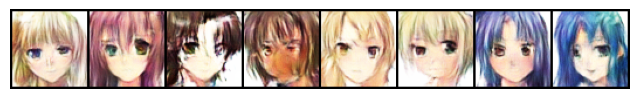

 72%|███████████████████████████████████████████████████████████                       | 36/50 [17:26<05:43, 24.54s/it]

[Epoch 36/50] [Loss C: -5.27739953994751] [Loss G: 1.342728853225708]



 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [17:50<05:18, 24.51s/it]

[Epoch 37/50] [Loss C: -4.967926025390625] [Loss G: -2.0979318618774414]



 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [18:15<04:52, 24.38s/it]

[Epoch 38/50] [Loss C: -5.8149189949035645] [Loss G: 3.021704912185669]



 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [18:38<04:24, 24.06s/it]

[Epoch 39/50] [Loss C: -6.618269920349121] [Loss G: -1.5558744668960571]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:23<00:00, 41.58it/s]

[Epoch 40/50] [Loss C: -4.389954090118408] [Loss G: -2.904616355895996]
Generated images at epoch 40:


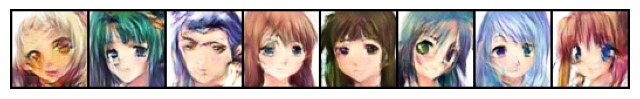

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [19:26<03:35, 23.96s/it]

[Epoch 41/50] [Loss C: -4.783527851104736] [Loss G: 1.5916357040405273]



 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [19:50<03:11, 23.94s/it]

[Epoch 42/50] [Loss C: -4.71647310256958] [Loss G: -4.558306694030762]



 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [20:13<02:47, 23.89s/it]

[Epoch 43/50] [Loss C: -4.775938987731934] [Loss G: 2.366926670074463]



 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [20:37<02:23, 23.85s/it]

[Epoch 44/50] [Loss C: -4.12938928604126] [Loss G: -6.653265476226807]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:23<00:00, 41.52it/s]

[Epoch 45/50] [Loss C: -5.584385871887207] [Loss G: 1.5380291938781738]
Generated images at epoch 45:


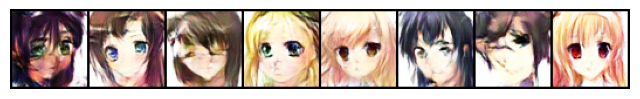

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [21:25<01:35, 23.89s/it]

[Epoch 46/50] [Loss C: -5.826807022094727] [Loss G: 0.11940231174230576]



 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [21:49<01:11, 23.88s/it]

[Epoch 47/50] [Loss C: -4.403250694274902] [Loss G: 1.8095248937606812]



 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [22:12<00:47, 23.77s/it]

[Epoch 48/50] [Loss C: -6.222873687744141] [Loss G: 0.5651314854621887]



 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [22:35<00:23, 23.60s/it]

[Epoch 49/50] [Loss C: -4.285852432250977] [Loss G: 2.719217300415039]



100%|████████████████████████████████████████████████████████████████████████████████| 994/994 [00:23<00:00, 41.73it/s]

[Epoch 50/50] [Loss C: -4.284430027008057] [Loss G: 1.8822053670883179]
Generated images at epoch 50:


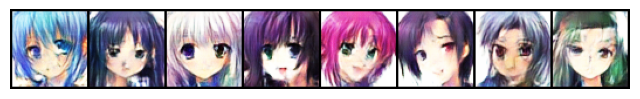

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [22:59<00:00, 27.60s/it]


In [15]:
g_losses, c_losses = train(dataloader, generator, critic, optimizer_C, optimizer_G, epochs, lambda_gp, n_critic, device, num_images)

### Отрисовка генераций после обучения

Что вы можете сказать о качестве полученных изображений?

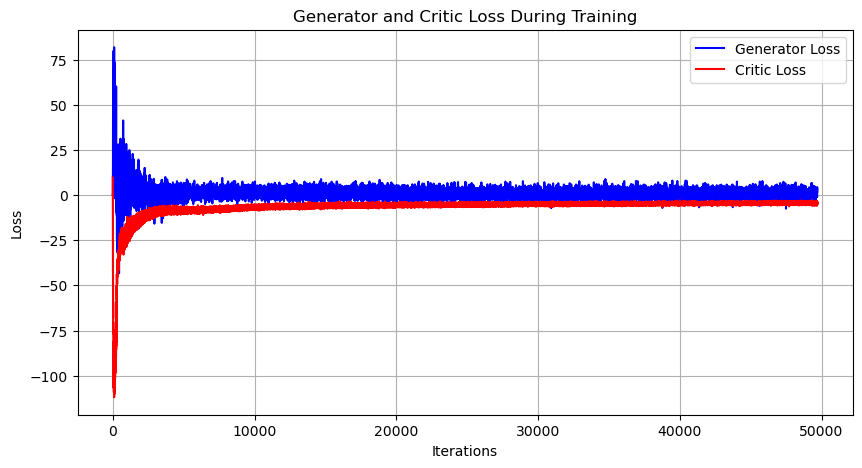

In [18]:
def plot_losses(g_losses, c_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Critic Loss During Training")
    plt.plot(g_losses, label="Generator Loss", color='blue')
    plt.plot(c_losses, label="Critic Loss", color='red')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Вызов после тренировки
plot_losses(g_losses, c_losses)

## Часть 3. Способы оценки качества генераций (2 балла)

### Подсчет accuracy (1 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (**sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)**) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет [sklearn.model_selection.LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html).

Такой способ оценки достаточно долгий, поэтому возьмите только часть изображений. Например, 500 реальных картинок и 500 фейковых.

In [16]:
num_images = 500

In [26]:
# Генерация изображений
generator.eval()
z = torch.randn(num_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = generator(z).cpu()
fake_images = (fake_images + 1) / 2.0
fake_images = fake_images.permute(0, 2, 3, 1).cpu().numpy()  # [N,H,W,C]
fake_images = fake_images.reshape(num_images, -1) 

In [27]:
# Подготовка реальных изображений
real_images = []
count = 0
for batch, _ in dataloader:
    batch = batch[:min(num_images - count, batch.size(0))]  # ограничиваем, если батч больше
    batch = (batch + 1) / 2.0  # [-1,1] -> [0,1]
    batch = batch.permute(0, 2, 3, 1).cpu().numpy()
    batch = batch.reshape(batch.shape[0], -1)
    real_images.append(batch)
    count += batch.shape[0]
    if count >= num_images:
        break
real_images = np.vstack(real_images)  # [num_images, H*W*C]

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

In [29]:
X = np.vstack([real_images, fake_images])
y = np.hstack([np.ones(num_images), np.zeros(num_images)])

loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

accuracies = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append((y_pred == y_test).item())

accuracy = np.mean(accuracies)
print(f"1NN Leave-One-Out Accuracy: {accuracy:.4f}")

1NN Leave-One-Out Accuracy: 0.5800


### Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

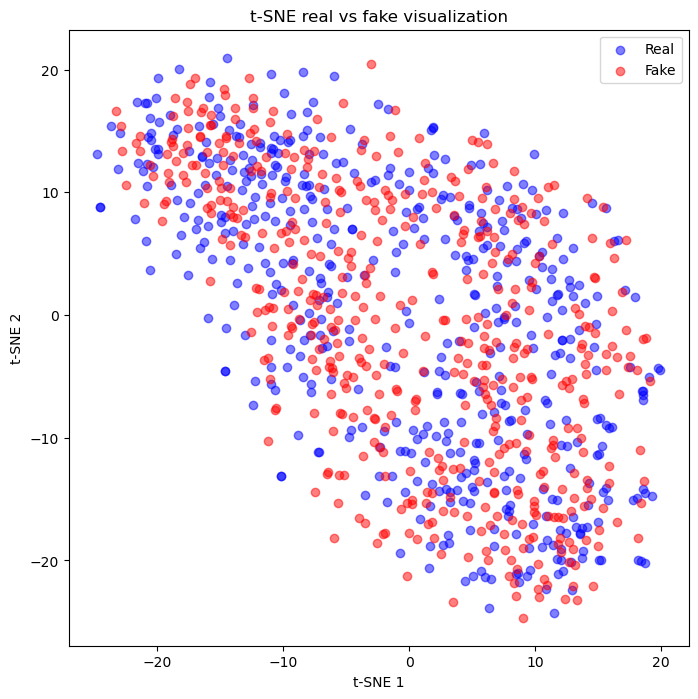

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ------------------------------
# 1. Подготовка данных
# ------------------------------
num_images = 500

# Генерация фейковых изображений
generator.eval()
z = torch.randn(num_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = generator(z)
fake_images = (fake_images + 1) / 2.0  # [-1,1] -> [0,1]
fake_images = fake_images.permute(0, 2, 3, 1).cpu().numpy()
fake_images = fake_images.reshape(num_images, -1)  # [N, H*W*C]

# Подготовка реальных изображений
real_images_list = []
count = 0
for batch, _ in dataloader:
    batch = batch[:min(num_images - count, batch.size(0))]
    batch = (batch + 1) / 2.0  # [-1,1] -> [0,1]
    batch = batch.permute(0, 2, 3, 1).cpu().numpy()
    batch = batch.reshape(batch.shape[0], -1)
    real_images_list.append(batch)
    count += batch.shape[0]
    if count >= num_images:
        break
real_images = np.vstack(real_images_list)

# Объединяем данные
X = np.vstack([real_images, fake_images])
y = np.hstack([np.ones(num_images), np.zeros(num_images)])  # 1 = real, 0 = fake

# ------------------------------
# 2. TSNE
# ------------------------------
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)  # [2*num_images, 2]

# ------------------------------
# 3. Визуализация
# ------------------------------
plt.figure(figsize=(8,8))
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], c='blue', label='Real', alpha=0.5)
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], c='red', label='Fake', alpha=0.5)
plt.legend()
plt.title("t-SNE real vs fake visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


Прокомментируйте получившийся результат:
По группировкам точек можно сказать, что визуально они распределеяются на +-похожие кластеры. 